# **Exoplanets and Solar System Planets: Data Analysis & Visualization**

*Author: Anton Zaitsev*  
*Date: January 26, 2024*

# Data References

## NASA Exoplanet Archive

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

NASA Exoplanet Archive dataset contains information on confirmed planets outside of the Solar System, e.g. planet mass, radius, planet discovery method, orbital period, etc.

Rows: 35131
Columns: 286

> To download: in the link, click 'Download Table' on the top left corner, check 'Download all Columns', 'Download all Rows' 'Values only' and then click 'Download Table'.

## Solar System Major Bodies Data

https://www.kaggle.com/datasets/jaredsavage/solar-system-major-bodies-data

The Solar System Planets dataset contains information on major bodies inside the Solar System, including planets, such as Earth, Mars, Venus, etc. It includes information on body's attributes, such as mass, density, etc.

Rows: 31
Columns: 265

## Equilibrium Temperatures for Solar Planets

http://astro.vaporia.com/start/equilibriumtemperature.html

This reference contains data (table) for equilibrium temperatures for planets inside the Solar System.

## The Distances from the Solar Planets to the Earth

https://promenade.imcce.fr/en/pages5/573.html

This reference contains data (table) for the distances for planets inside the Solar System to Earth.

## Habitable Zone Boudaries Calculation

https://www.planetarybiology.com/calculating_habitable_zone.html

We used this reference for the formula on how to calculate star inner and outer habitable zone boundaries.

## Solar System Habitable Zone Boundaries

https://www.britannica.com/science/habitable-zone

This article provides information on the habitable zone of the Sun.

## The Habitability of Planets Orbiting M-dwarf Stars

https://arxiv.org/pdf/1610.05765.pdf

In this paper, A. L. Shields, S. Ballard and J. A. Johnson provide a "comprehensive picture of the current knowledge of M-dwarf planet occurrence
and habitability based on work done in this area over the past decade". This paper was only used as an inspiration for the 'Habitable Zone Boundaries' plot.

## Sun Fact Sheet

https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html

This page contains data on Sun.

## Sun Age

https://ui.adsabs.harvard.edu/abs/1989ApJ...339.1156G/abstract#:~:text=The%20age%20of%20the%20sun,4.49%20%2B%20or%20%2D%200.04%20Gyr.

This page contains information about approximate Sun age.

## Kepler-22 b and Kepler-553 c

Kepler-22 b: https://exoplanets.nasa.gov/exoplanet-catalog/1599/kepler-22b/

Kepler-553 c: https://exoplanets.nasa.gov/exoplanet-catalog/6009/kepler-553-c/

This two pages contain information and animation for these 2 exoplanets.

---------



# Imports

In [46]:
import warnings
warnings.simplefilter('ignore', category=UserWarning)
import os
os.makedirs('plots', exist_ok=True)
os.makedirs('data', exist_ok=True)
from ast import literal_eval
from typing import List
from IPython.display import Markdown

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
from scipy.spatial import ConvexHull
from scipy import interpolate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Global Variables

In [47]:
EXOPLANETS_PATH = 'data/exoplanets.csv'
EXOPLANETS_HEADER = 290
SOLARPLANETS_URL = 'data/solarplanets.csv'
PLOTS_SAVE_DIR = 'plots/'

COLORS = [
    '#BCE6DA', '#6EB4CD', '#3680D0', '#445792', '#433E7D', '#3F2B5C', 
    '#612F55', '#B13D54', '#CC4F4C', '#E66143', '#F3995D', '#FED2AA'
]
STAR_COLORS = [
    '#FB110A', '#FC6609', '#FDA62A', '#FADA17', '#FDF759', '#efefc5',
    '#D5E8EE', '#96D2DF', '#338fb8', '#1c5aa0', '#172b89','#18147a'
]
STAR_COLOR = '#fbef83'
PRIMARY_COLOR_START = '#49B0D5'
PRIMARY_COLOR_START_2 = '#3680D0'
PRIMARY_COLOR_MIDDLE = '#742963'
PRIMARY_COLOR_END = '#C63331'

COLOR_PALETTE = sns.color_palette(COLORS, 12)
GRADIENT_COLOR_CMAP = LinearSegmentedColormap.from_list('gradient_cmap', COLORS)
COLOR_CMAP = ListedColormap(GRADIENT_COLOR_CMAP(np.linspace(0, 1, 256)), name='listed_cmap')
STAR_GRADIENT_COLOR_CMAP = LinearSegmentedColormap.from_list('star_gradient_cmap', STAR_COLORS)
STAR_COLOR_CMAP = ListedColormap(STAR_GRADIENT_COLOR_CMAP(np.linspace(0, 1, 256)), name='star_listed_cmap')

TITLE_SIZE = 16
SUBTITLE_SIZE = 14
AXIS_TITLE_SIZE = 12

# Data Preparation

## Exoplanets

In [48]:
columns_considered = [
    'pl_name', 'hostname', 'disc_year', 'discoverymethod', 
    'pl_controv_flag', 'sy_snum', 'sy_pnum', 'sy_mnum',
    'pl_orbper', 'pl_orbsmax', 
    'pl_rade', 'pl_masse', 'pl_dens',
    'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl',
    'st_teff', 'st_rad', 'st_mass', 'st_lum', 
    'st_logg', 'st_age', 'st_dens', 'st_vsin',
    'sy_dist', 'ra', 'dec'
]
# read exoplanets data
# only use columns specified in 'columns_considered'
exoplanets_dirty = pd.read_csv(EXOPLANETS_PATH, header=EXOPLANETS_HEADER, usecols=columns_considered, index_col=None)

# remove duplicates
columns_group = ['pl_name', 'hostname', 'disc_year', 'discoverymethod']
exoplanets = exoplanets_dirty.groupby(columns_group).mean()
exoplanets = exoplanets.reset_index()


## Solar Planets

In [49]:
# read solar data
solar_bodies = pd.read_csv(SOLARPLANETS_URL)

# add 'eName' column specifying planet names
solarplanets_names = {'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'}
solarplanets = solar_bodies[solar_bodies['eName'].isin(solarplanets_names)].reset_index()

# add 'Sun' as hosting star
solarplanets['hostname'] = 'Sun'

# add planet temperature data
# data taken from: http://astro.vaporia.com/start/equilibriumtemperature.html
solarplanets['pl_eqt'] = [64, 51, 122, 226, 449, 90, 279, 328]

# add distance to earth data
# data taken from: https://promenade.imcce.fr/en/pages5/573.html
au_parcec = 206265
solarplanets['earth_dist_avg'] = [
    (17.292 + 21.089)/au_parcec,
    (28.817 + 31.317)/au_parcec,
    (3.957 + 6.454)/au_parcec,
    (0.372 + 2.671)/au_parcec,
    (0.552 + 1.446)/au_parcec,
    (8.050 + 11.046)/au_parcec,
    0/au_parcec,
    (0.266 + 1.736)/au_parcec
]

# add sun mass as 1
solarplanets['st_mass'] = 1

# add sun temperature
# data taken from: https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
solarplanets['st_teff'] = 5722

# add sun radius, mass, luminosity, surface gravity, age and density to the solarplanets data
sun_rad = 1
sun_mass = 1
sun_luminosity = 0
sun_logg = np.log10(27400) # data taken from: https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
sun_age = 4.51 # data taken from: https://ui.adsabs.harvard.edu/abs/1989ApJ...339.1156G/abstract#:~:text=The%20age%20of%20the%20sun,4.49%20%2B%20or%20%2D%200.04%20Gyr.
sun_dens = 1.408 # data taken from: https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
solarplanets['st_rad'] = sun_rad
solarplanets['st_lum'] = sun_luminosity
solarplanets['st_logg'] = sun_logg
solarplanets['st_age'] = sun_age
solarplanets['st_dens'] = sun_dens

# convert features to earth scale
earth_mass = solarplanets.loc[solarplanets['eName'] == 'Earth', 'mass_kg'].values[0]
earth_radius = solarplanets.loc[solarplanets['eName'] == 'Earth', 'meanRadius'].values[0]
solarplanets['mass_earth'] = solarplanets['mass_kg'] / earth_mass
solarplanets['radius_earth'] = solarplanets['meanRadius'] / earth_radius

# rename column to match with exoplanets
solarplanets_rename_cols = {
    'mass_earth': 'pl_masse', 'sideralOrbit': 'pl_orbper', 
    'semimajorAxis_AU': 'pl_orbsmax', 'radius_earth': 'pl_rade', 
    'pl_eqt': 'pl_eqt', 'eName': 'pl_name', 'earth_dist_avg': 'sy_dist',
    'eccentricity': 'pl_orbeccen'}
solarplanets.rename(columns=solarplanets_rename_cols, inplace=True)

# define earth and mars data separately
earth = solarplanets[solarplanets['pl_name'] == 'Earth']
mars = solarplanets[solarplanets['pl_name'] == 'Mars']

# Data for Orbital Period & Temperature Animation

In [50]:
# pick only relevant columns for exoplanets and solarplanets
animation_cols= ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_eqt', 'pl_name', 'sy_dist']
exoplanets_animation = exoplanets[animation_cols]
solarplanets_animation = solarplanets[animation_cols]
earth_animation = earth[animation_cols]
# concatenate exoplanets and solarplanets into one dataframe
solar_exo_animation = pd.concat([exoplanets_animation, solarplanets_animation, earth_animation], ignore_index=True)
solar_exo_animation = solar_exo_animation.dropna(subset=['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_eqt', 'sy_dist'])

# Exploratory Analysis

## How Exoplanets were Discovered & Their Location in the Sky

> - An astronomical unit (AU) is a unit of measurement equal to the average distance between a planet and its host star.
>   - 1 AU is the average distance from the Earth to the Sun.
>   - 1 AU = 1.5 x 10^8 KM (150 million kilometers)
>   - 1 Parsec = 206,265 AU
>   - 1 Parsec = 3.09 x 10^13 KM

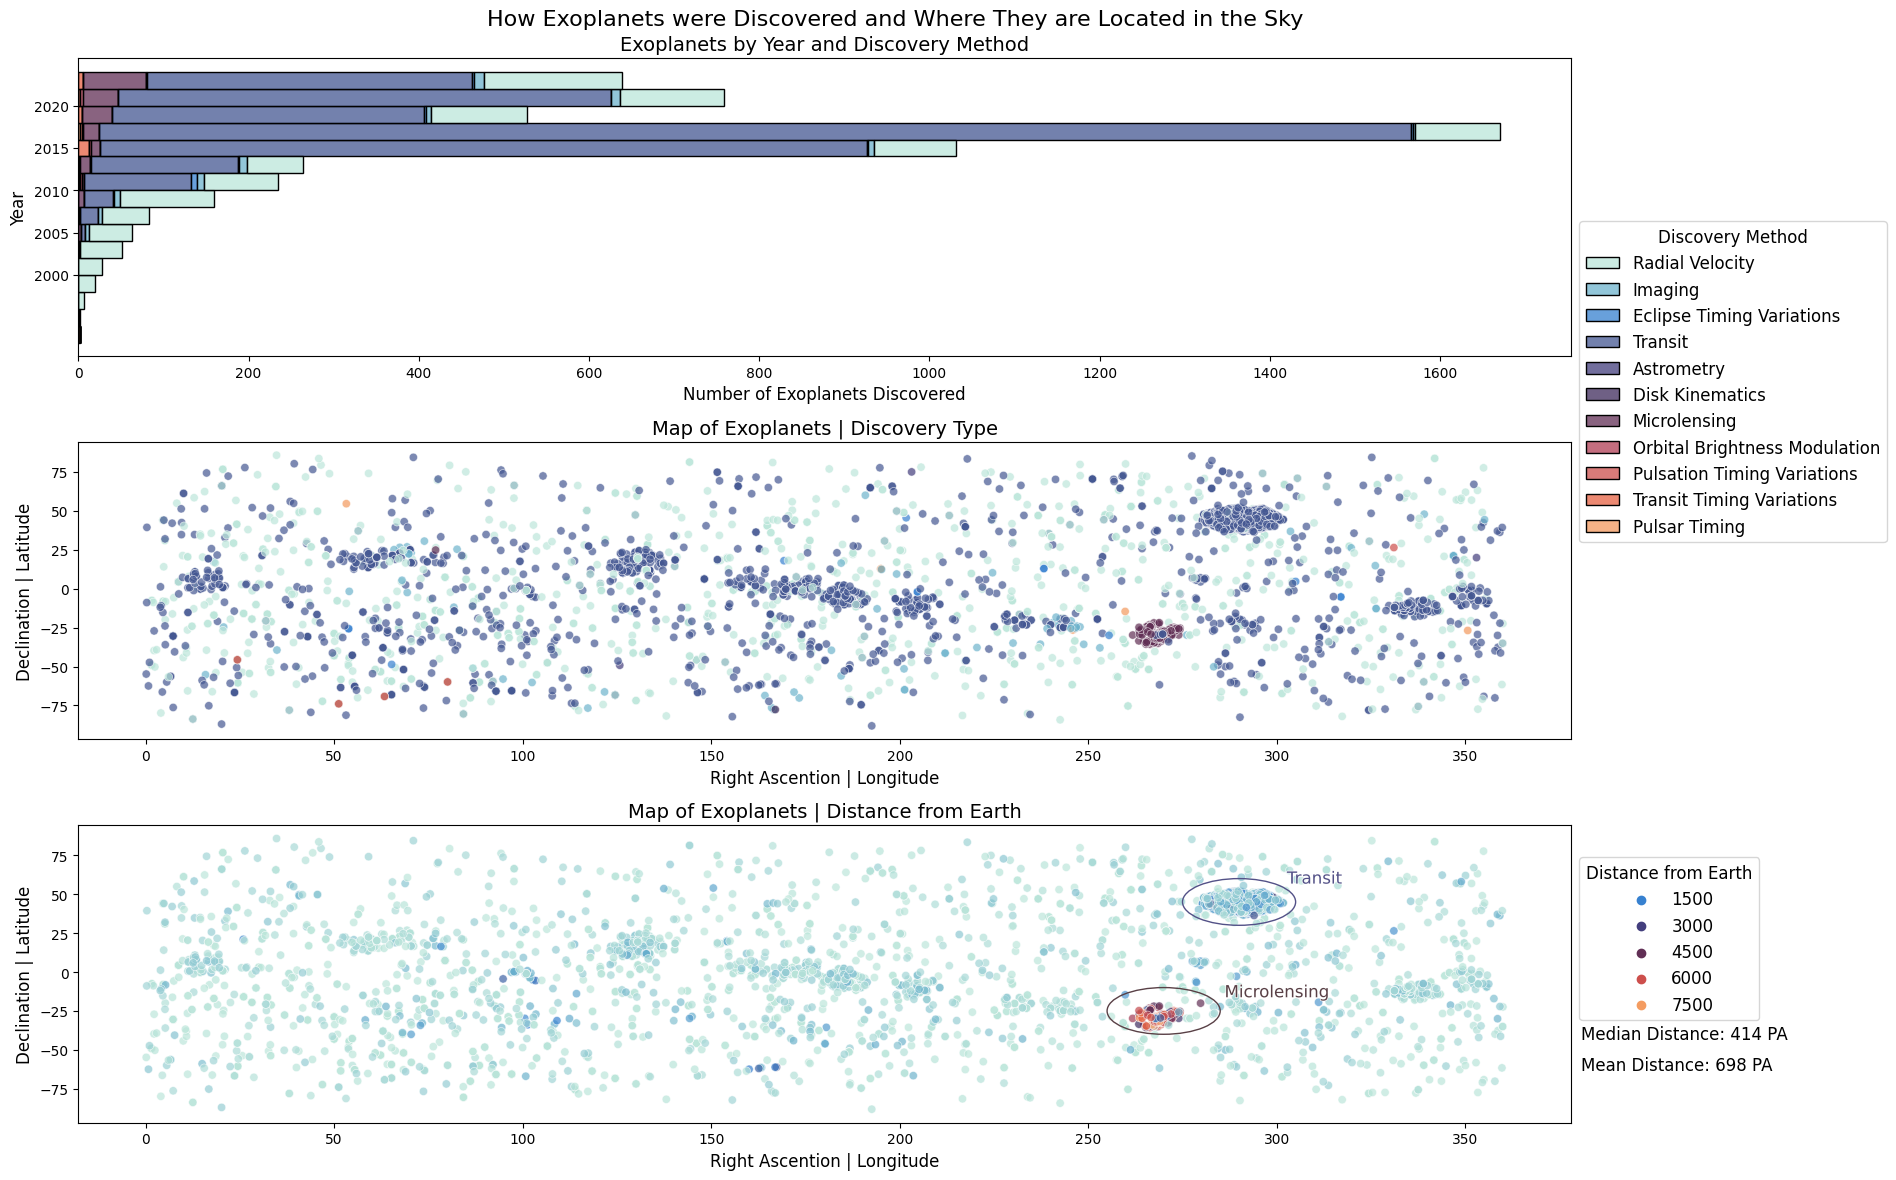

In [51]:
# create figure and grid for 3 separate plots
fig = plt.figure(figsize=(18, 12))
gridspan = fig.add_gridspec(3, 1)

# define axes 
ax1 = fig.add_subplot(gridspan[0, :])
ax2 = fig.add_subplot(gridspan[1, :])
ax3 = fig.add_subplot(gridspan[2, :])

# create first histogram plot
ax1_legend = sns.histplot(
    data=exoplanets, 
    y='disc_year', 
    multiple="stack",
    binwidth=2, 
    hue='discoverymethod', 
    palette=COLOR_PALETTE,
    ax=ax1
).get_legend()
ax1.set_title('Exoplanets by Year and Discovery Method', fontsize=SUBTITLE_SIZE)
ax1.set_xlabel('Number of Exoplanets Discovered',fontsize=AXIS_TITLE_SIZE)
ax1.set_ylabel('Year',fontsize=AXIS_TITLE_SIZE)
ax1.set_yticks(range(2000, max(exoplanets['disc_year'])+1, 5))

# create 2nd scatterplot
sns.scatterplot(
    x='ra', 
    y='dec', 
    hue='discoverymethod', 
    palette=COLOR_PALETTE,
    data=exoplanets, 
    alpha=0.7, 
    ax=ax2
)
ax2.set_title("Map of Exoplanets | Discovery Type", fontsize=SUBTITLE_SIZE)
ax2.set_xlabel("Right Ascention | Longitude", fontsize=AXIS_TITLE_SIZE)
ax2.set_ylabel("Declination | Latitude", fontsize=AXIS_TITLE_SIZE)

# create 3rd scatter plot
ax3_legend = sns.scatterplot(
    x='ra', 
    y='dec', 
    hue='sy_dist', 
    palette=COLOR_CMAP,
    data=exoplanets, 
    alpha=0.7, 
    ax=ax3
).get_legend()
ax3.set_title("Map of Exoplanets | Distance from Earth", fontsize=SUBTITLE_SIZE)
ax3.set_xlabel("Right Ascention | Longitude", fontsize=AXIS_TITLE_SIZE)
ax3.set_ylabel("Declination | Latitude", fontsize=AXIS_TITLE_SIZE)

# manually add 'Transit' and 'Microlensing' labels to the last plot
# most common methods, i.e. 'Transit' and 'Microlensing', for two planet clusters on the last plot was calculated beforehand
transit_circle_center = (290, 45)
transit_circle_radius = 15
transit_circle = plt.Circle(transit_circle_center, transit_circle_radius, fill=False, color='#535187')
microlensing_circle_center = (270, -25)
microlensing_circle_radius = 15
microlensing_circle = plt.Circle(microlensing_circle_center, microlensing_circle_radius, fill=False, color='#594046')
ax3.add_patch(transit_circle)
ax3.add_patch(microlensing_circle)
ax3.text(310, 60, 'Transit', ha='center', va='center', color='#535187', fontsize=12, path_effects=[pe.withStroke(linewidth=1, foreground="white")])
ax3.text(300, -13, 'Microlensing', ha='center', va='center', color='#594046', fontsize=12, path_effects=[pe.withStroke(linewidth=1, foreground="white")])

# calculate mean and median distance from earth to exoplanets
exo_dist_med = int(exoplanets['sy_dist'].median())
exo_dist_mean = int(exoplanets['sy_dist'].mean())
ax3.text(408, -40, f"Median Distance: {exo_dist_med} PA", ha='center', va='center', color='black', fontsize=12)
ax3.text(406, -60, f"Mean Distance: {exo_dist_mean} PA", ha='center', va='center', color='black', fontsize=12)

# create 2 legends
handles1, labels1 = ax1_legend.legendHandles, [text.get_text() for text in ax1_legend.get_texts()]
handles3, labels3 = ax3_legend.legendHandles, [text.get_text() for text in ax3_legend.get_texts()]
fig.legend_ = None
fig.legend(handles=handles1, labels=labels1, title='Discovery Method', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.8755, 0.81), loc='upper left')
fig.legend(handles=handles3, labels=labels3, title='Distance from Earth', fontsize=12, title_fontsize=12, bbox_to_anchor=(0.8755, 0.28), loc='upper left')
ax1.legend([]).set_visible(False)
ax2.legend([]).set_visible(False)
ax3.legend([]).set_visible(False)

fig.suptitle("How Exoplanets were Discovered and Where They are Located in the Sky", fontsize=TITLE_SIZE)
plt.tight_layout()
plt.savefig(f"{PLOTS_SAVE_DIR}discovery_distance", bbox_inches='tight')
plt.show()

## Distribution Analysis of Exoplanetary Parameters, including Earth Comparison

Here, we will explore statistical distributions of various exoplanetary parameters and compare these values with analogous parameter values observed on Earth.

> - **Planetary radius** refers to the average distance from the center to the outer boundary of a celestial body, such as a planet, providing a measure of its size.
> - **Orbital period** is the time it takes for a celestial object, such as a planet, to complete one full revolution around its host star or a central point in its orbit.
> - **Orbital distance** is the measure of how far a planet is from its hosting star.
> - **Equilibrium Temperature** is an estimate of the temperature a planet or celestial body would have if it were a simple black body, thus not subject to atmospheric windows, internal heat sources, etc.
>   - Does not count the **greenhouse effect** !
> - Some Earth data for reference:
    >   - Earth radius = 6.371 x 10^3 km
    >   - Earth mass = 5.972 x 10^24 kg
    >   - Earth orbital distance = 1 AU
    >   - Earth's Equilibrium Temperature: ≈ 255K = -18C

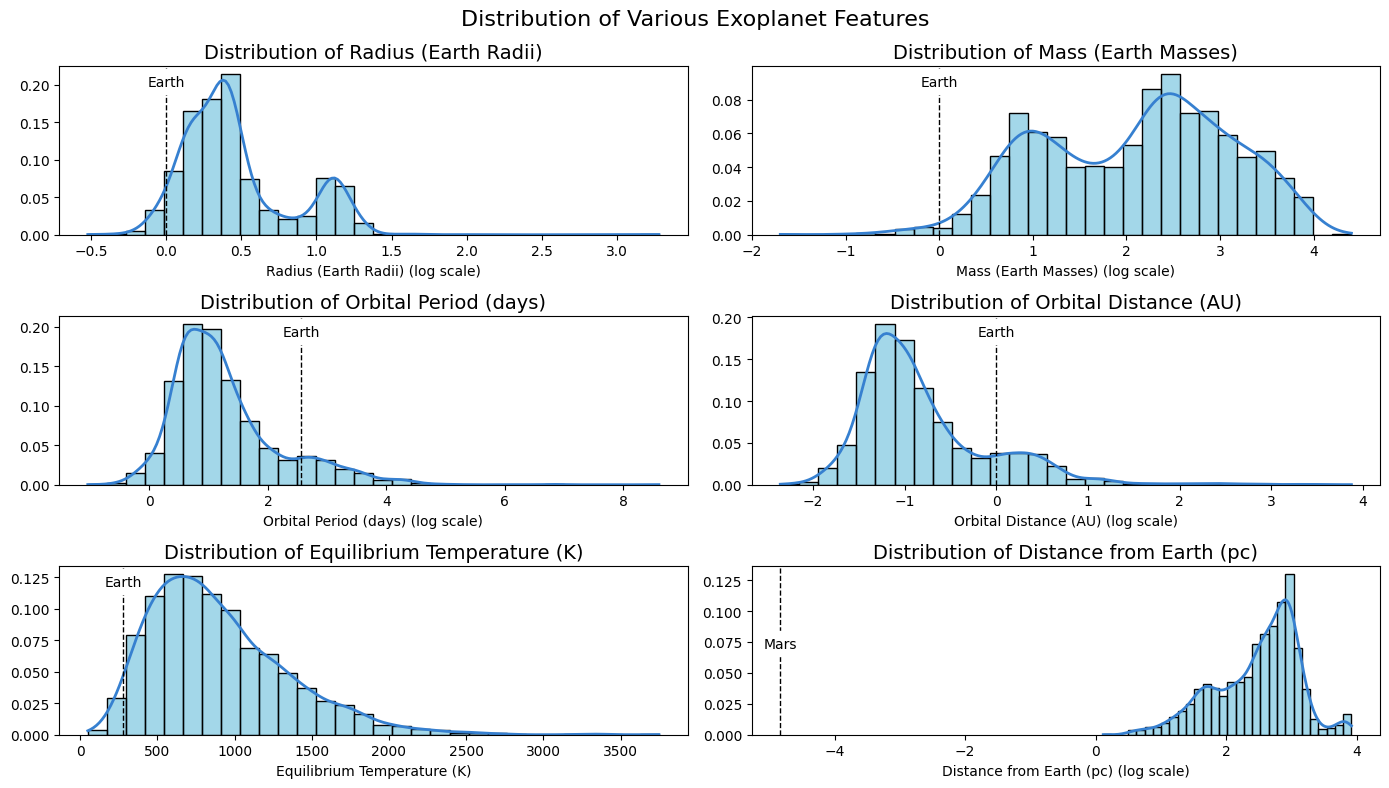

In [52]:
# map columns to proper names
column_mapping = {
    'pl_rade': 'Radius (Earth Radii)',
    'pl_masse': 'Mass (Earth Masses)',
    'pl_orbper': 'Orbital Period (days)',
    'pl_orbsmax': 'Orbital Distance (AU)',
    'pl_eqt': 'Equilibrium Temperature (K)',
    'sy_dist': 'Distance from Earth (pc)',
}
columns_to_plot = list(column_mapping.keys())

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
axes = axes.flatten()

# iterate through each column
# and create according distribution plot
for i, column in enumerate(columns_to_plot):
    data = exoplanets[column] if column == 'pl_eqt' else np.log10(exoplanets[column])
    hist = sns.histplot(x=data, bins=30, stat='probability', kde=True, color=PRIMARY_COLOR_START, line_kws={'lw': 2}, ax=axes[i])
    hist.lines[0].set_color(PRIMARY_COLOR_START_2)
    
    # do not include Earth into plot if column == 'sy_dist' (distance from earth)
    if (column != 'sy_dist'):
        earth_distance = earth[column].iloc[0] if column == 'pl_eqt' else np.log10(earth[column].iloc[0])
        axes[i].axvline(earth_distance, color='black', linestyle='--', label='Earth', linewidth=1)
        axes[i].text(earth_distance, axes[i].get_ylim()[1]*6.5/7.5, 'Earth', color='black', va='bottom', ha='center', backgroundcolor='white', fontsize=10)
    # if column == 'sy_dist', then add Mars label and vline to it
    else:
        mars_distance = np.log10(mars['sy_dist']).values[0]
        axes[i].axvline(mars_distance, color='black', linestyle='--', label='Mars', linewidth=1)
        axes[i].text(mars_distance, axes[i].get_ylim()[1]/2, 'Mars', color='black', va='bottom', ha='center', backgroundcolor='white', fontsize=10)

    # do not log scale 'pl_eqt' column
    if column == 'pl_eqt':
        axes[i].set_xlabel(f'{column_mapping[column]}')
    else:
        axes[i].set_xlabel(f'{column_mapping[column]} (log scale)')
    axes[i].set_ylabel('')
    axes[i].set_title(f'Distribution of {column_mapping[column]}', fontsize=SUBTITLE_SIZE)

fig.suptitle("Distribution of Various Exoplanet Features", fontsize=TITLE_SIZE)
plt.tight_layout()
plt.savefig(f"{PLOTS_SAVE_DIR}distribution", bbox_inches='tight')
plt.show()

## How Distance to Star Affects Planet's Temperature and Rotational Period

### Prepare Data for Plots

In [63]:
# IMPORTANT!
# In order to fully reconstruct the Planet Rotation Period & Temperature animation plot, 
#   change decreased values for the number of frames and the number of exoplanets (100 and 100 in the code) 
#   to the according values specified in the comments. 
# Beware: using full num_planets and num_frames will take a lot of time to generate the animation, 
#    which is around 30-40 minutes for the animation generation (depends on the processor power)
num_planets = 50 # len(solar_exo_animation)
num_frames = 50 # 4000
# define starting distance to move planets away from the center, i.e. star
# do not change this value
starting_distance = 6

In [64]:
orbital_periods = solar_exo_animation['pl_orbper'][:num_planets].values
orbital_distances = np.log10(solar_exo_animation['pl_orbsmax'][:num_planets].values)

# calculate angles for all frames and planets using broadcasting
angles = (np.pi * np.arange(num_frames)[:, np.newaxis] / (12 * orbital_periods))
# calculate distances for all frames and planets using broadcasting
distances = (orbital_distances + starting_distance)
# calculate x and y positions for all frames and planets using broadcasting
x_positions = distances * np.sin(angles)
y_positions = distances * np.cos(angles)
# create planet sizes matrix using broadcasting and duplicate the planet_sizes array for all frames
planet_sizes = np.tile(solar_exo_animation['pl_rade'][:num_planets].values.reshape(1, -1), (num_frames, 1))

### Rotational Period & Planet Temperature Animation

In [65]:
# create figure and grid for 3 separate plots
fig = plt.figure(figsize=(16, 8))
gridspan = fig.add_gridspec(2, 2)

# define axes 
ax1 = fig.add_subplot(gridspan[0, :])
ax2 = fig.add_subplot(gridspan[1, 0])
ax3 = fig.add_subplot(gridspan[1, 1])

ax1.set_xlim(-10.5, 10.5)
ax1.set_ylim(-10.5, 10.5)
ax1.set_xlabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)
ax1.set_ylabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)

# normalize color map
norm = Normalize(vmin=solar_exo_animation['pl_eqt'].min(), vmax=solar_exo_animation['pl_eqt'].max())

# define scatter moving plots that will update based on the current frame (including Earth label)
k_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap=COLOR_CMAP, alpha=0.8, norm=norm)
s_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap=COLOR_CMAP, norm=norm)
earth_scatter = ax1.scatter(x=[], y=[], s=50, c=[], cmap=COLOR_CMAP, edgecolors='black', norm=norm)
earth_text = ax1.text(0, 0, 'Earth', color='black', ha='right', va='bottom')

# define star in the middle of the animation
star = ax1.scatter(x=0, y=0, s=4500, color=STAR_COLOR, edgecolors='black', alpha=0.5)

# create color bar based on planets temperature
cbar_kp = plt.colorbar(k_p, ax=ax1)
cbar_kp.set_label('Temperature (K)', rotation=270, labelpad=15)

# update function that will update scatter data based on the current frame
def update(i):
    k_p.set_offsets(np.column_stack((x_positions[i % num_frames, :len(solar_exo_animation) - 8],
                                    y_positions[i % num_frames, :len(solar_exo_animation) - 8])))
    k_p.set_sizes(planet_sizes[i % num_frames, :len(solar_exo_animation) - 8])
    k_p.set_array(solar_exo_animation['pl_eqt'].iloc[:len(solar_exo_animation) - 8])
    s_p.set_offsets(np.column_stack((x_positions[i % num_frames, -8:-1],
                                    y_positions[i % num_frames, -8:-1])))
    s_p.set_sizes(planet_sizes[i % num_frames, -8:-1])
    s_p.set_array(solar_exo_animation['pl_eqt'].iloc[-8:-1])
    earth_scatter.set_offsets(np.column_stack((x_positions[i % num_frames, -1],
                                    y_positions[i % num_frames, -1])))
    earth_scatter.set_array([solar_exo_animation['pl_eqt'].iloc[-1]])
    earth_text.set_position((x_positions[i % num_frames, -1], y_positions[i % num_frames, -1]))
    return k_p, s_p, earth_scatter, earth_text

# second scatter plot
ax2.set_xlim(0, 1.2)
ax2.set_ylim(0, 500)
ax2.scatter(
    x=solar_exo_animation['pl_orbsmax'], 
    y=solar_exo_animation['pl_orbper'], 
    c=solar_exo_animation['pl_eqt'],
    s=solar_exo_animation['pl_rade'], 
    cmap=COLOR_CMAP, 
    alpha=0.6
)
ax2.annotate(
    'Earth', 
     xy=(earth_animation['pl_orbsmax'], earth_animation['pl_orbper']),
     xytext=(5, 5),
     textcoords='offset points',
     ha='right',
     va='bottom',
     fontsize=8,
     color='black'
)
ax2.set_xlabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)
ax2.set_ylabel('Orbital Period (Days)', fontsize=AXIS_TITLE_SIZE)
ax2.set_title('How Distance affects Temperature', fontsize=SUBTITLE_SIZE)

# third scatter plot
ax3.set_xlim(0, 0.2)
ax3.set_ylim(0, 40)
ax3.scatter(
    x=solar_exo_animation['pl_orbsmax'], 
    y=solar_exo_animation['pl_orbper'], 
    c=solar_exo_animation['pl_eqt'],
    s=solar_exo_animation['pl_rade'], 
    cmap=COLOR_CMAP, 
    alpha=0.6
)
ax3.set_xlabel('Distance from Star (AU)', fontsize=AXIS_TITLE_SIZE)
ax3.set_ylabel('Orbital Period (Days)', fontsize=AXIS_TITLE_SIZE)
ax3.set_title('How Distance affects Temperature (Closer Look)', fontsize=SUBTITLE_SIZE)

fig.suptitle("How Distance to Star Affects Planet's Temperature and Rotational Period", fontsize=TITLE_SIZE)
plt.tight_layout()
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=200, repeat=False)
ani.save(f"{PLOTS_SAVE_DIR}planets_orbiting_star_animation.gif", writer='pillow', fps=30)
plt.close()

![Rotational Period & Temperature Animation](plots/planets_orbiting_star_animation_full.gif)

## Which planets are Inhabitable?

### Calculating & Plotting Habitable Zone Boundaries

#### Preparing Data

In [9]:
def hab_zone_boundaries_lum(stellar_luminosity: int) -> tuple:
    """
    Calculate inner and outer boundaries of the habitable zone based on stellar luminosity.

    Formula reference: https://www.planetarybiology.com/calculating_habitable_zone.html
    Inner boundary: R_i=sqrt(L, i_c)
    Outer boundary: R_o=sqrt(L, o_c)
    where:
    - L: star luminosity
    - i_c = 1.1: inner zone coefficient
    - o_c = 0.53: outer zone coefficient

    Parameters:
    - stellar_luminosity: Stellar luminosity in log10(Solar) scale.

    Returns:
    - inner_boundary: Inner boundary of the habitable zone in AU.
    - outer_boundary: Outer boundary of the habitable zone in AU.
    """

    outer_coefficint = 0.53
    inner_coefficient = 1.1

    outer_boundary = np.sqrt(10 ** stellar_luminosity / outer_coefficint)
    inner_boundary = np.sqrt(10 ** stellar_luminosity / inner_coefficient)

    return outer_boundary, inner_boundary

def hab_remove_outliers(dataframe: pd.DataFrame, window_size: int, column: str, cutoff_threshold: float) -> List[int]:
    """
    Remove outliers from a specified column in a DataFrame using a rolling window approach.

    Note: this function can probably be optimized by removing the for loops and making vectorized computations.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame containing the data.
    - window_size (int): The size of the rolling window used for outlier detection.
    - column (str): The name of the column for which outliers are to be removed.
    - cutoff_threshold (float): The threshold for identifying outliers, expressed as a percentage.

    Returns:
    - List[int]: A list of indices corresponding to rows identified as outliers based on the specified criteria.
    """
    start = 0
    frames = len(dataframe)//window_size
    indecies = []
    for frame in range(frames):
        window_median = dataframe[column].iloc[start:start+window_size].median()
        for idx, row in dataframe.iloc[start:start+window_size].iterrows():
            if (abs(row[column]-window_median))/window_median > cutoff_threshold:
                indecies.append(idx)
        start += window_size
    for idx, row in dataframe.iloc[start:-1].iterrows():
        window_median = dataframe[column].iloc[start:-1].median()
        if (abs(row[column]-window_median))/window_median > cutoff_threshold:
            indecies.append(idx)

    return indecies

In [10]:
# calculate inner and outer zone boundaries for each star
exoplanets[['hab_zone_inner', 'hab_zone_outer']] = exoplanets['st_lum'].apply(
    lambda lum: pd.Series(hab_zone_boundaries_lum(lum))
)
exoplanets_hab = exoplanets.copy()
exoplanets_hab = exoplanets_hab.dropna(subset=['hab_zone_inner', 'hab_zone_outer', 'st_mass'])
exoplanets_hab = exoplanets_hab.sort_values(by='st_mass')

# remove outliers, which essentially ruin the habitable zone boundaries lines
outliers_indecies = hab_remove_outliers(exoplanets_hab, 200, 'hab_zone_inner', 0.2)
exoplanets_hab = exoplanets_hab.drop(outliers_indecies)
exoplanets_hab = exoplanets_hab.sort_values(by='st_mass')

# define outliers data, where planet's temperature is too high according to its distance from the star
# label then as 'Wrong data?' in the plot
outliers_hab = exoplanets_hab[
    (exoplanets_hab['pl_orbsmax'] > 10**0) & 
    (exoplanets_hab['pl_eqt'] > 10**3)
]
outliers_hab = outliers_hab[outliers_hab['pl_name'] != 'GSC 06214-00210 b']

# add inner and outer zone boundaries for the solar planets
# data taken from: https://www.britannica.com/science/habitable-zone
solarplanets['hab_zone_inner'] = 0.9
solarplanets['hab_zone_outer'] = 1.53

# find planets that are located inside the habitable zone
exoplanets_hab_in = exoplanets_hab[(exoplanets_hab['pl_orbsmax'] < exoplanets_hab['hab_zone_inner']) & (exoplanets_hab['pl_orbsmax'] > exoplanets_hab['hab_zone_outer'])].dropna(subset=['pl_eqt'])
solarplanets_hab_in = solarplanets[(solarplanets['pl_orbsmax'] > solarplanets['hab_zone_inner']) & (solarplanets['pl_orbsmax'] < solarplanets['hab_zone_outer'])]

#### Habitable Zone Boundaries Plot

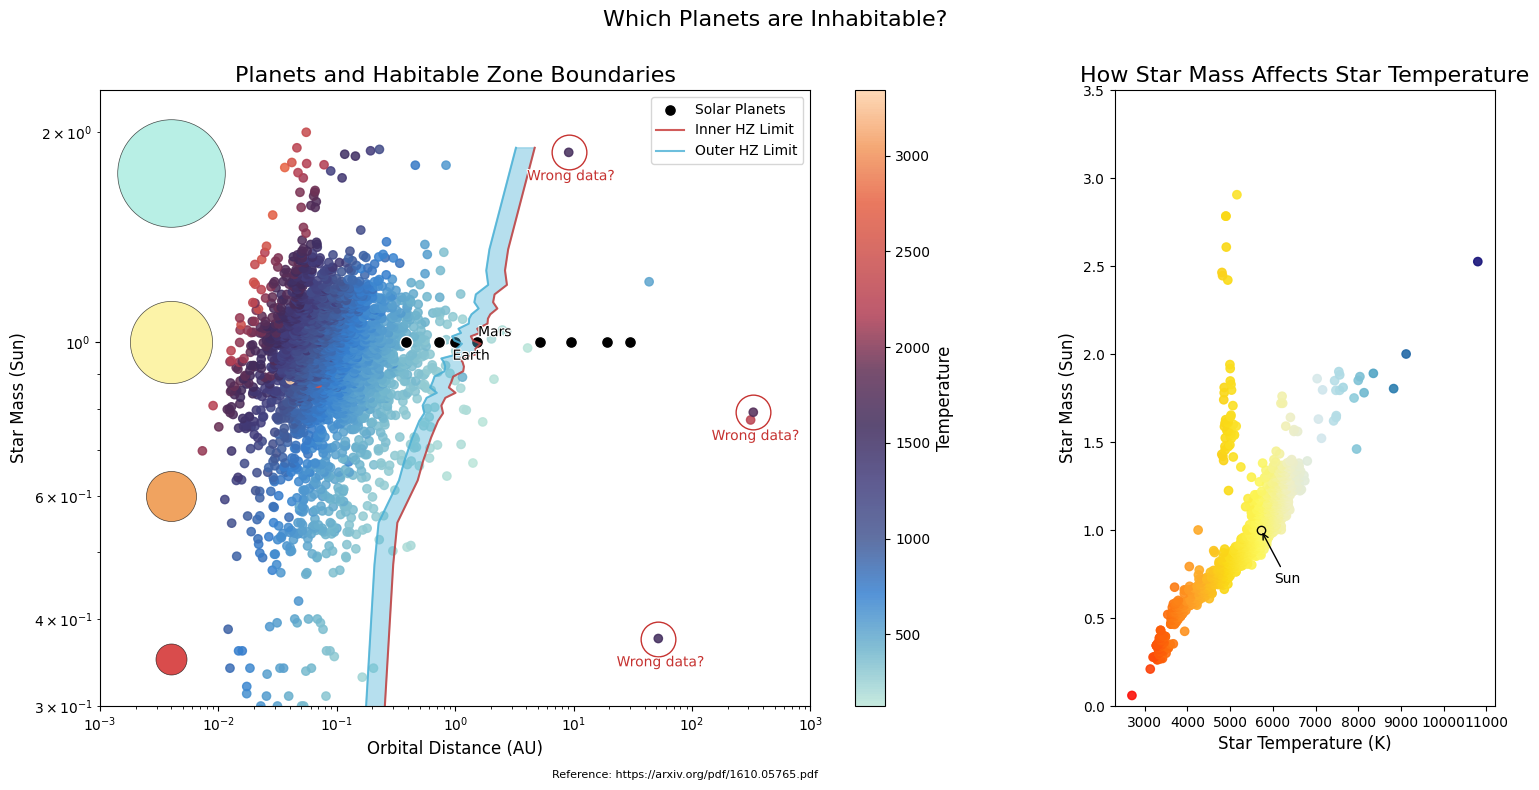

In [11]:
# define figure, grid for 2 plots
fig = plt.figure(figsize=(18, 8))
gridspan = fig.add_gridspec(1, 2, width_ratios=[7, 3])

ax1 = fig.add_subplot(gridspan[0, 0])
ax2 = fig.add_subplot(gridspan[0, 1])

# define first scatter plot
# include solar planets for reference
scatter_exoplanets = ax1.scatter(x=exoplanets_hab['pl_orbsmax'], y=exoplanets_hab['st_mass'], c=exoplanets_hab['pl_eqt'], alpha=0.85, cmap=COLOR_CMAP)
ax1.scatter(x=solarplanets['pl_orbsmax'], y=solarplanets['st_mass'], label='Solar Planets', s=75, color='black', edgecolor='white', alpha=1)
# add line for habitable zone boundaries, but only pick every 81 planet for the line
# otherwise the line is difficult to interpet due to the high variations
ax1.plot(exoplanets_hab['hab_zone_inner'][::81], exoplanets_hab['st_mass'][::81], label='Inner HZ Limit', color=PRIMARY_COLOR_END, alpha=0.8)
ax1.plot(exoplanets_hab['hab_zone_outer'][::81], exoplanets_hab['st_mass'][::81], label='Outer HZ Limit', color=PRIMARY_COLOR_START, alpha=0.8)
inner_limit = exoplanets_hab['hab_zone_inner'][::81]
outer_limit = exoplanets_hab['hab_zone_outer'][::81]
st_mass = exoplanets_hab['st_mass'][::81]
# add coloring between the boundaries
ax1.fill_betweenx(st_mass, inner_limit, outer_limit, color=PRIMARY_COLOR_START, alpha=0.4)

# add Mars and Earth labels
planet_names = ['Earth', 'Mars']
planet_text_xys = [(25, -15), (25, 2)]
for planet_name, planet_text_xy in zip(planet_names, planet_text_xys):
    ax1.annotate(
        planet_name, 
        xy=(solarplanets[solarplanets['pl_name']==planet_name]['pl_orbsmax'], solarplanets[solarplanets['pl_name']==planet_name]['st_mass']),
        xytext=planet_text_xy,
        textcoords='offset points',
        ha='right',
        va='bottom',
        fontsize=10,
        color='black',
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
)

# add 4 stars that grow in size according to its mass on the very left of the first plot
star_x = 10**(-3)*4
star_y = [0.35, 0.6, 1, 1.75]
star_sizes = [500, 1300, 3500, 6000]
star_colors = ['#c90000', '#eb7c1c', STAR_COLOR, '#9be9da']
for idx, _ in enumerate(star_y):
    ax1.scatter(x=star_x, y=star_y[idx], s=star_sizes[idx], marker='o', color=star_colors[idx], edgecolors='black', linewidth=0.5, alpha=0.7)

# label outliers on the plot
outliers_x = outliers_hab['pl_orbsmax']
outliers_y = outliers_hab['st_mass']
for x, y in zip(outliers_x, outliers_y):
    ax1.plot(x, y, marker='o', ms=25, mfc='none', mec=PRIMARY_COLOR_END)
    ax1.annotate(
        'Wrong data?', (x, y), textcoords="offset points", xytext=(-30,-20), ha='left', 
        fontsize=10, color=PRIMARY_COLOR_END, path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
    )

# scale data, set limits
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(10**(-3), 10**3)
ax1.set_ylim(0.3, 10**0+1.3)

# create colorbar for planets' temperatures
cbar = plt.colorbar(scatter_exoplanets, orientation='vertical', ax=ax1)
cbar.set_label('Temperature', fontsize=AXIS_TITLE_SIZE)

ax1.set_title('Planets and Habitable Zone Boundaries', fontsize=TITLE_SIZE)
ax1.set_xlabel('Orbital Distance (AU)', fontsize=AXIS_TITLE_SIZE)
ax1.set_ylabel('Star Mass (Sun)', fontsize=AXIS_TITLE_SIZE)
ax1.legend(loc='upper right')
# add a reference to the paper which demostrates similar plot for habitable zone boundaries
reference_text = 'Reference: https://arxiv.org/pdf/1610.05765.pdf'
fig.text(0.45, 0.02, reference_text, wrap=True, horizontalalignment='center', fontsize=8)

# create 2nd scatter plot
scatter_stars = ax2.scatter(x=exoplanets_hab['st_teff'], y=exoplanets_hab['st_mass'], c=exoplanets_hab['st_teff'], alpha=0.9, cmap=STAR_COLOR_CMAP)
ax2.scatter(solarplanets['st_teff'].values[0], 1, color=STAR_COLOR, edgecolor='black', marker='o', label='Sun')
# add 'Sun' label and arrow pointing to it
ax2.annotate('Sun', xy=(solarplanets['st_teff'].values[0], 1), xytext=(solarplanets['st_teff'].values[0] + 300, 0.7), arrowprops=dict(facecolor='black', arrowstyle='->'))
ax2.set_ylim(0, 3.5)
ax2.set_title('How Star Mass Affects Star Temperature', fontsize=TITLE_SIZE)
ax2.set_xlabel('Star Temperature (K)', fontsize=AXIS_TITLE_SIZE)
ax2.set_ylabel('Star Mass (Sun)', fontsize=AXIS_TITLE_SIZE)

fig.suptitle("Which Planets are Inhabitable?", fontsize=TITLE_SIZE)
plt.savefig(f"{PLOTS_SAVE_DIR}habitable_zone", bbox_inches='tight')
plt.show()

### Clustering Analysis, including Earth

#### Preparing Data

In [12]:
# pick only the following columns for the cluster analysis
habitable_columns = [
    'pl_name', 'hostname', 
    'pl_rade', 'pl_eqt', 'pl_orbeccen', 'pl_orbsmax',
    'st_teff', 'st_rad', 'st_mass', 'st_lum', 'st_logg', 'st_age', 'st_dens'
]
# scale of the features:
# pl_rade [Earth Radius], pl_eqt [K], pl_orbeccen,
# st_teff [K], st_rad [Sun Radius], st_mass [Solar Mass], st_lum [log10(Solar)], st_logg [log10(cm/s**2)], st_age [Gyr], st_dens [g/cm**3]
habitable = exoplanets_hab_in[habitable_columns]
# drom NaN values
habitable_exo = habitable.dropna()

# define Earth and Mars as habitable planets to include them in the cluster analysis
habitable_solar = solarplanets[(solarplanets['pl_name']=='Earth') | (solarplanets['pl_name']=='Mars')][habitable_columns]

# concatenate habitable exoplanets and solarplanets
habitable_exo_solar = pd.concat([habitable_exo, habitable_solar], ignore_index=True)

# define table with planets inside the habitable zone
# but only use 'pl_name', 'hostname', 'sy_dist', 'pl_eqt' columns
habitable_exo_dist = exoplanets[exoplanets['pl_name'].isin(exoplanets_hab_in['pl_name'])][['pl_name', 'hostname', 'sy_dist', 'pl_eqt']]

#### K-Means and PCA

In [13]:
# drop categorical features
habitable_kmeans = habitable_exo_solar.drop('pl_name', axis=1).drop('hostname', axis=1)

# define training data for K-Means
X = habitable_kmeans.values

# scale training data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)
x_scaled_df = pd.DataFrame(data=x_scaled, columns=habitable_kmeans.columns)

# define maximum number of clusters
k_max = 9

# define data for the Elbow method plot
wcss = []
for i in range(1, k_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# define data for the Silhouette method plot
k_values = range(2, k_max)
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# finding the K value with the maximum silhouette score
max_silhouette_index = np.argmax(silhouette_scores)
max_silhouette_k = k_values[max_silhouette_index]
max_silhouette_score = silhouette_scores[max_silhouette_index]

# perform k-means algorithm
# use 3 as the number of clusters
# note: we can also use num_clusters=max_silhouette_k, but here we decided to use 3 for better illustration
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=42)
kmeans_clusters = kmeans.fit_predict(x_scaled)
earth_like_indexes = indexes = np.where(kmeans_clusters == 1)[0]

# perform PCA to reduce dimensionallity to 2
pca = PCA()
principal_components = pca.fit_transform(x_scaled)[:, :2]
explained_variance_ratio = pca.explained_variance_ratio_

# create a dictionary specifying the number of points for each cluster, as well as its center
cluster_centers = {i: {'num_points': 0, 'center': 0} for i in range(num_clusters)}
for sample in range(len(principal_components)):
    cluster = kmeans_clusters[sample]
    cluster_centers[cluster]['num_points'] += 1
    cluster_centers[cluster]['center'] += principal_components[sample]
for cluster in cluster_centers:
    cluster_centers[cluster]['center'] /= cluster_centers[cluster]['num_points']

# create a dataframe specifying assigned cluster and cluster center for each data point
pc_clusters = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_clusters['Cluster'] = kmeans_clusters
pc_clusters['Center'] = None
for idx, cluster in enumerate(kmeans_clusters):
    pc_clusters.loc[idx, 'Center'] = str(cluster_centers[cluster]['center'].tolist())

#### Clustering Analysis Plot

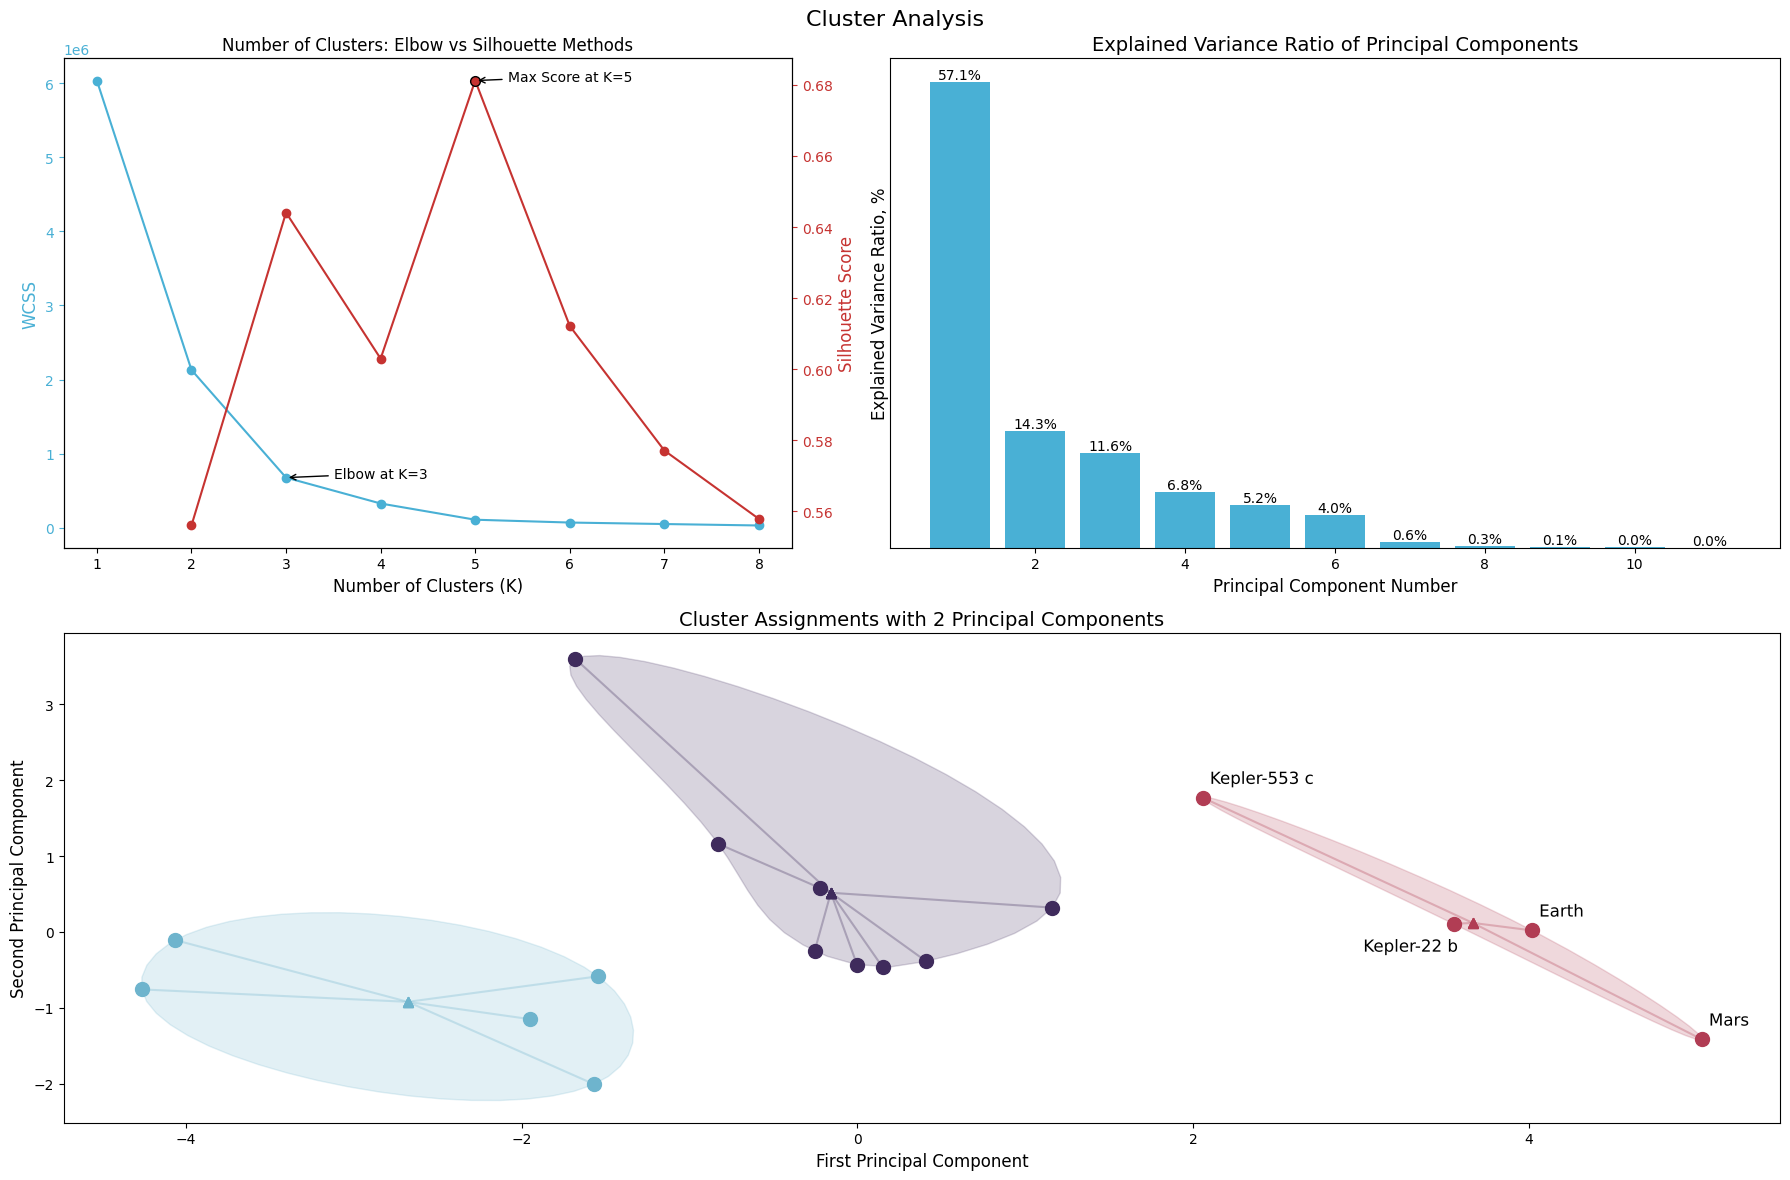

In [14]:
# define figure, grid for 3 plots
fig = plt.figure(figsize=(18, 12))
gridspan = fig.add_gridspec(2, 2, width_ratios=[4.5, 5.5])

# define axes
ax1 = fig.add_subplot(gridspan[0, 0])
ax3 = fig.add_subplot(gridspan[0, 1])
ax4 = fig.add_subplot(gridspan[1, :])

# Elbow method plot
ax1.plot(range(1, k_max), wcss, marker='o', color=PRIMARY_COLOR_START, label='WCSS')
ax1.set_xlabel('Number of Clusters (K)', fontsize=AXIS_TITLE_SIZE)
ax1.set_ylabel('WCSS', color=PRIMARY_COLOR_START, fontsize=AXIS_TITLE_SIZE)
ax1.tick_params('y', colors=PRIMARY_COLOR_START)
ax1.annotate(
    f'Elbow at K=3',
    xy=(3, wcss[2]),
    xytext=(4, wcss[2]),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    horizontalalignment='center',
    fontsize=10
)
ax1.set_title('Number of Clusters: Elbow vs Silhouette Methods')

# define Silhouette method plot on the same axis as the Elbow method plot
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, marker='o', color=PRIMARY_COLOR_END, label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color=PRIMARY_COLOR_END, fontsize=AXIS_TITLE_SIZE)
ax2.tick_params('y', colors=PRIMARY_COLOR_END)
ax2.plot(max_silhouette_k, max_silhouette_score, marker='o', markersize=7, color=PRIMARY_COLOR_END, fillstyle='none', markeredgecolor='black')
ax2.annotate(
    f'Max Score at K={max_silhouette_k}',
    xy=(max_silhouette_k, max_silhouette_score),
    xytext=(max_silhouette_k + 1, max_silhouette_score),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    horizontalalignment='center',
    fontsize=10
)

# PCA variance ratio plot
bars = ax3.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color=PRIMARY_COLOR_START)
for bar in bars:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1%}', ha='center', va='bottom', color='black', fontsize=10)
ax3.set_xlabel('Principal Component Number', fontsize=AXIS_TITLE_SIZE)
ax3.set_ylabel('Explained Variance Ratio, %', labelpad=-3, fontsize=AXIS_TITLE_SIZE)
ax3.set_yticks([])
ax3.set_title('Explained Variance Ratio of Principal Components', fontsize=SUBTITLE_SIZE)

# cluster plot
cluster_colors = ['#6EB4CD', '#B13D54', '#3F2B5C']
for sample in range(len(x_scaled)):
    cluster = cluster_centers[kmeans_clusters[sample]]
    ax4.scatter(principal_components[sample][0], principal_components[sample][1], color=cluster_colors[kmeans_clusters[sample]], s=100)
    if sample in earth_like_indexes:
        planet_name = habitable_exo_solar.loc[sample]['pl_name']
        xytext = (5,10)
        # move label lower and to the left for this planet
        if planet_name=='Kepler-22 b':
            xytext = (-65,-20)
        ax4.annotate(
            planet_name, 
            (principal_components[sample][0], principal_components[sample][1]), 
            textcoords="offset points",
            color='black',
            fontsize=12,
            xytext=xytext,
            path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
        )
    if cluster['num_points'] != 1:
        ax4.scatter(cluster['center'][0], cluster['center'][1], marker='^', c=cluster_colors[kmeans_clusters[sample]], s=50)

# show cluster centers
for idx, val in pc_clusters.iterrows():
    center = literal_eval(val['Center'])
    x = [val['PC1'], center[0]]
    y = [val['PC2'], center[1]]
    ax4.plot(x, y, c=cluster_colors[kmeans_clusters[idx]], alpha=0.3)

# create a convex hull for each cluster
for i in pc_clusters['Cluster'].unique():
    points = pc_clusters[pc_clusters['Cluster'] == i][['PC1', 'PC2']].values
    if len(points) == 1:
        continue
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0, per=1)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    # plot shape
    ax4.fill(interp_x, interp_y, '--', c=cluster_colors[i], alpha=0.2)

ax4.set_xlabel('First Principal Component', fontsize=AXIS_TITLE_SIZE)
ax4.set_ylabel('Second Principal Component', fontsize=AXIS_TITLE_SIZE)
ax4.set_title('Cluster Assignments with 2 Principal Components', fontsize=SUBTITLE_SIZE)

fig.suptitle("Cluster Analysis", fontsize=TITLE_SIZE)
plt.tight_layout()
plt.savefig(f"{PLOTS_SAVE_DIR}kmeans", bbox_inches='tight')
plt.show()

## Earth, Mars and Exoplanets that resemble Earth according to the K-Means Analysis

In [45]:
# define data for the table
habitable_close = pd.concat([
    earth[['pl_name', 'hostname', 'sy_dist', 'pl_eqt']],
    mars[['pl_name', 'hostname', 'sy_dist', 'pl_eqt']],
    habitable_exo_dist[habitable_exo_dist['pl_name']=='Kepler-553 c'],
    habitable_exo_dist[habitable_exo_dist['pl_name']=='Kepler-22 b']
]).reset_index().drop(columns=['index'])

# rename columns
habitable_close = habitable_close.rename(columns={'pl_name': 'Planet', 'hostname': 'Star', 'sy_dist': 'Distance (PC)', 'pl_eqt': 'Temperature (K)'})

# add some more data to the table
habitable_close['Time to Get (Years)'] = [
    0, 
    0.6, 
    round(exoplanets[exoplanets['pl_name']=='Kepler-553 c']['sy_dist'].values[0]*0.6/mars['sy_dist'].values[0],1), 
    round(exoplanets[exoplanets['pl_name']=='Kepler-22 b']['sy_dist'].values[0]*0.6/mars['sy_dist'].values[0],1)
]
habitable_close['Type'] = [
    'Earth', 
    'Mars', 
    'Gas Giant', # data taken from: https://exoplanets.nasa.gov/exoplanet-catalog/6009/kepler-553-c/
    'Super Earth, Super Ocean' # data taken from: https://exoplanets.nasa.gov/exoplanet-catalog/1599/kepler-22b/
]
habitable_close['Mass (Earth)'] = [
    earth['pl_masse'].values[0], 
    mars['pl_masse'].values[0], 
    317.5, # data taken from: https://exoplanets.nasa.gov/exoplanet-catalog/6009/kepler-553-c/
    exoplanets[exoplanets['pl_name']=='Kepler-22 b']['pl_masse'].values[0]
]
habitable_close['Radius (Earth)'] = [
    earth['pl_rade'].values[0], 
    mars['pl_rade'].values[0], 
    exoplanets[exoplanets['pl_name']=='Kepler-553 c']['pl_rade'].values[0], 
    exoplanets[exoplanets['pl_name']=='Kepler-22 b']['pl_rade'].values[0]
]
habitable_close['Orbital Period (days)'] = [
    earth['pl_orbper'].values[0], 
    mars['pl_orbper'].values[0], 
    exoplanets[exoplanets['pl_name']=='Kepler-553 c']['pl_orbper'].values[0], 
    exoplanets[exoplanets['pl_name']=='Kepler-22 b']['pl_orbper'].values[0]
]

habitable_close = habitable_close.round(1)
habitable_close.loc[habitable_close['Planet'] == 'Mars', 'Distance (PC)'] = mars['sy_dist'].values[0]

# title = "Earth, Mars and Exoplanets that resemble Earth according to the K-Means Analysis"
# styles = [
#     dict(selector="caption",
#     props=[("text-align", "center"),
#     ("font-size", "150%"),
#     ("color", 'white')])
# ]
# habitable_close = habitable_close.style.set_caption(title).set_table_styles(styles)

habitable_close

,Planet,Star,Distance (PC),Temperature (K),Time to Get (Years),Type,Mass (Earth),Radius (Earth),Orbital Period (days)
0,Earth,Sun,0.000000,279.0,0.0,Earth,1.0,1.0,365.3
1,Mars,Sun,0.000015,226.0,0.6,Mars,0.1,0.5,687.0
2,Kepler-553 c,Kepler-553,728.500000,235.6,29629157.2,Gas Giant,317.5,11.4,328.2
3,Kepler-22 b,Kepler-22,194.600000,264.1,7916102.3,"Super Earth, Super Ocean",22.6,2.2,289.9
